# Demo - Gaussianization Flow

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF
from rbig_jax.transforms.logit import InitLogitTransform
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF
from rbig_jax.transforms.parametric.householder import InitHouseHolder
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse


KEY = jax.random.PRNGKey(seed=123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn import datasets
from typing import Iterator, Mapping
import numpy as np

Batch = Mapping[str, np.ndarray]


def load_dataset(
    n_train: int,
    batch_size: int,
    seed: int,
    n_samples: int = 2_000,
    noise: float = 0.05,
) -> Iterator[Batch]:
    X, y = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=seed)
    ds = tf.data.Dataset.from_tensor_slices((X))
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))

In [17]:
# train/valid dataset loaders
# wandb_logger.config.batch_size = 128
n_init_samples = 10_000

init_ds = load_dataset(n_init_samples, n_init_samples, 123, noise=0.1)

# demo batch
init_X = next(init_ds)

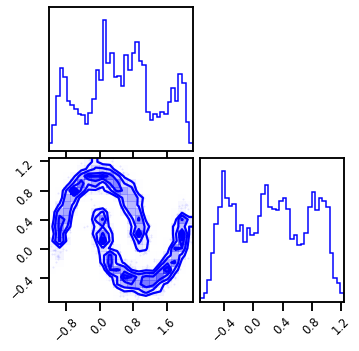

In [18]:
# plot data
fig = corner.corner(init_X, color="blue", hist_bin_factor=2)

In [19]:
from typing import Optional
from chex import Array
from einops import rearrange

PRNGKey = Array


def prepare_data(batch: Batch) -> Array:

    # select image from tfds
    batch = batch.astype(jnp.float32)

    return batch

## Model

In [26]:
from rbig_jax.models.gaussflow import init_gf_spline_model

# initialization data
n_init_samples = 10_000

init_ds = load_dataset(n_init_samples, n_init_samples, 100)
init_ds = next(init_ds)
init_data_prepped = prepare_data(init_ds)
X_init = np.array(init_data_prepped)

# marginal uniformization
n_bins = 16
range_min = -12
range_max = 12
boundary_slopes = "unconstrained"
identity_init = False

# rotation transformation
n_reflections = 4
init_rotation = "random"

# nn params
n_blocks = 10
squeeze = "sigmoid"

In [27]:
# init model
gf_model = init_gf_spline_model(
    shape=X_init.shape[1:],
    X=X_init,
    n_blocks=n_blocks,
    n_bins=n_bins,
    range_min=range_min,
    range_max=range_max,
    boundary_slopes=boundary_slopes,
    identity_init=identity_init,
    init_rotation=init_rotation,
    n_reflections=n_reflections,
    #     squeeze=squeeze,
)

Initializing - Block: 10 | Layer 19: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


In [28]:
X_g = gf_model.forward(X_init)
# X_g, X_ldj = gf_model.forward_and_log_det(X_init)

# gf_model.score(X_init)

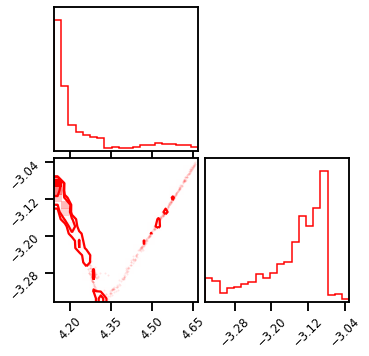

In [29]:
fig = corner.corner(np.array(X_g), color="Red")
plt.show()

## Training

### Optimizer

In [30]:
from rbig_jax.training.parametric import init_optimizer

n_epochs = 10_000
# initialize optimizer
optimizer = init_optimizer(
    "adam",
    n_epochs=n_epochs,
    lr=1e-3,
    cosine_decay_steps=None,
    warmup=None,
    gradient_clip=15.0,
    alpha=1e-1,
)

### Train Step

In [31]:
from rbig_jax.training.parametric import GaussFlowTrainer

# initial flow trainer
nf_trainer = GaussFlowTrainer(gf_model, optimizer, n_epochs=n_epochs)

In [32]:
train_ds = load_dataset(10_000, 256, 123)

eval_loss = 0.0
eval_frequency = 50
with tqdm.trange(n_epochs) as pbar:
    for step in pbar:

        # Train Step
        output = nf_trainer.train_step(next(train_ds))
        train_loss = output.loss
        pbar.set_description(
            f"Train Loss: {train_loss:.4f} | Valid Loss: {eval_loss:.4f}"
        )

        # Eval Step
        if step % eval_frequency == 0:
            output = nf_trainer.validation_step(next(train_ds))
            eval_loss = output.loss
            pbar.set_description(
                f"Train Loss: {train_loss:.4f} | Valid Loss: {eval_loss:.4f}"
            )

gf_model = output.model

Train Loss: 0.3643 | Valid Loss: 0.3467: 100%|██████████| 5000/5000 [02:06<00:00, 39.45it/s]  


### Results

#### Losses

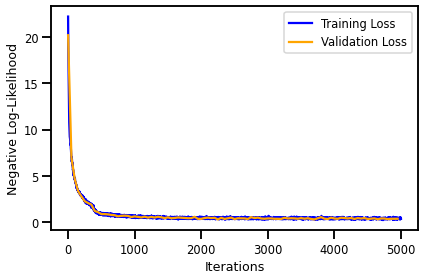

In [33]:
fig, ax = plt.subplots()
ax.plot(
    nf_trainer.train_epoch, nf_trainer.train_loss, label="Training Loss", color="blue"
)
ax.plot(
    nf_trainer.valid_epoch,
    nf_trainer.valid_loss,
    label="Validation Loss",
    color="orange",
)
ax.set(
    xlabel="Iterations", ylabel="Negative Log-Likelihood",
)
plt.legend()
plt.tight_layout()
plt.show()

#### Latent Space

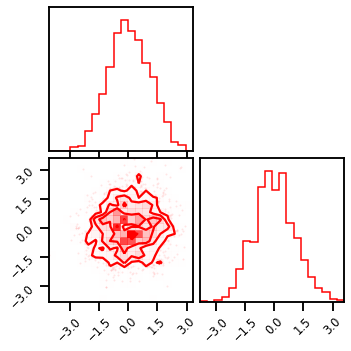

CPU times: user 2.61 s, sys: 86.2 ms, total: 2.7 s
Wall time: 2.51 s


In [34]:
%%time
n_eval_samples = 10_000
eval_ds = load_dataset(n_eval_samples, n_eval_samples, 200)
eval_ds =next(eval_ds)
X_trans = gf_model.forward(eval_ds)

fig = corner.corner(np.array(X_trans), color="Red")
plt.show()

#### Inverse Transform

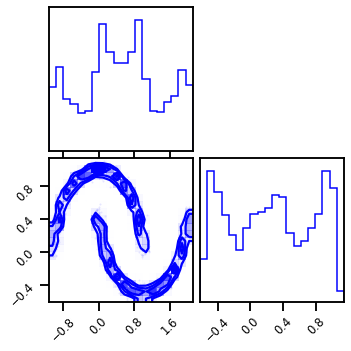

CPU times: user 2.86 s, sys: 73 ms, total: 2.93 s
Wall time: 2.74 s


In [35]:
%%time

X_approx = gf_model.inverse(X_trans)

fig = corner.corner(np.array(X_approx), color="Blue")
plt.show()

### Log Probability

#### Plot: Original Density

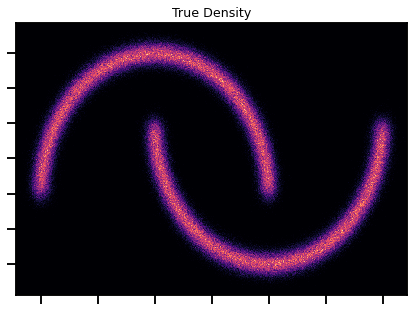

In [36]:
from matplotlib import cm

cmap = cm.magma
# Original Density
n_samples = 1_000_000
noise = 0.05
seed = 42
X_plot, _ = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=seed)


fig, ax = plt.subplots(figsize=(7, 5))
h = ax.hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True,  # vmin=0.0, vmax=1.0
)
ax.set_title("True Density")
ax.set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
plt.show()

In [37]:
%%time

n_grid = 500
buffer = 0.01
xline = jnp.linspace(X_init[:, 0].min() - buffer, X_init[:, 0].max() + buffer, n_grid)
yline = jnp.linspace(X_init[:, 1].min() - buffer, X_init[:, 1].max() + buffer, n_grid)
xgrid, ygrid = jnp.meshgrid(xline, yline)
xyinput = jnp.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

# calculate log probability
X_log_prob = gf_model.score_samples(xyinput)

CPU times: user 4.55 s, sys: 425 ms, total: 4.98 s
Wall time: 2.69 s


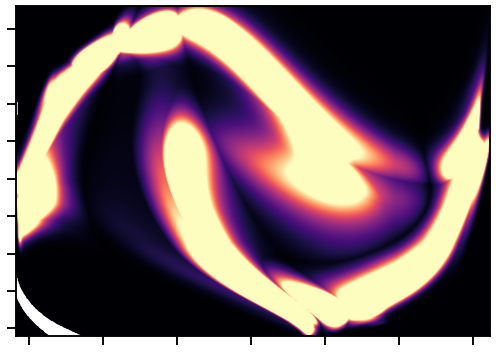

In [25]:
# # Original Density
# n_samples = 1_000_000
# ds_plot = PlaneDataset(n_samples=n_samples, noise=noise, seed=seed)
# X_plot = ds_plot[:]

# Estimated Density
cmap = cm.magma  # "Reds"
probs = jnp.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)


cmap = cm.magma  # "Reds"

fig, ax = plt.subplots(figsize=(7, 5))

h1 = ax.scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=0.2
)
ax.set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)


plt.tight_layout()
plt.show()

### Sampling

In [49]:
# %%time
# n_gen_samples = 100_000
# pred_batch_size = 10_000
# X_samples = []
# for _ in tqdm.trange(n_gen_samples // pred_batch_size):

#     X_samples.append(final_bijector.sample(seed=123, n_samples=pred_batch_size))

In [50]:
%%time

n_gen_samples = 100_000

X_samples = gf_model.sample(seed=123, n_samples=n_gen_samples)

CPU times: user 3.09 s, sys: 87.6 ms, total: 3.17 s
Wall time: 2.52 s


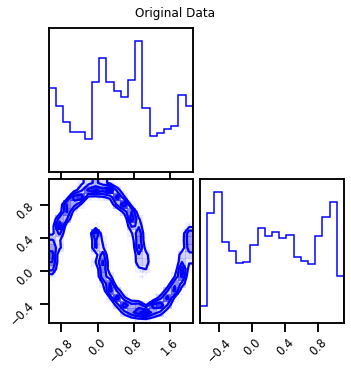

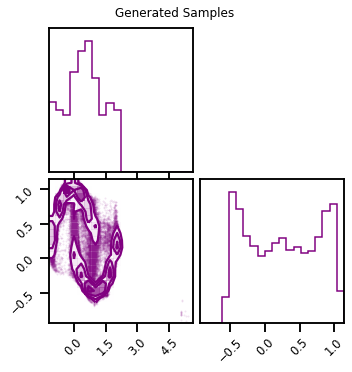

In [52]:
fig = corner.corner(np.array(X_init), color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(np.array(X_samples), color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Each Layer

#### Original

In [89]:
# X_g = X.copy()

# fig = corner.corner(X_g, color="purple")
# fig.suptitle("Initial")
# plt.show()

# for ilayer, ibijector in enumerate(gf_model.bijectors):

#     X_g = ibijector.forward(X_g)

#     if (ilayer+1) % 3 == 0:
#         fig = corner.corner(X_g, color="purple")
#         fig.suptitle(f"Block: {(ilayer+1)//3}")
#         plt.show()

#### Trained Model

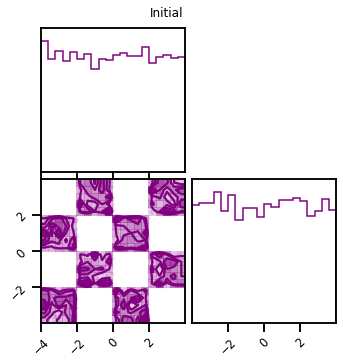

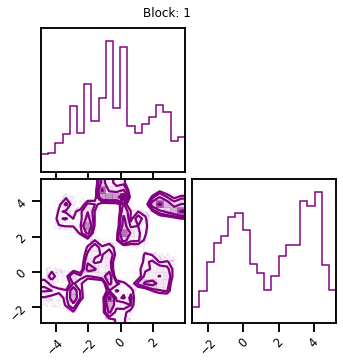

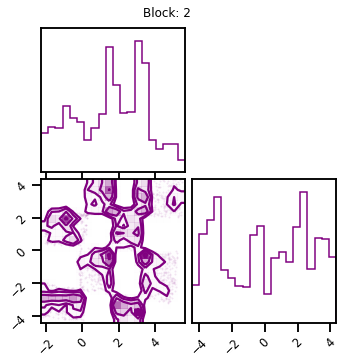

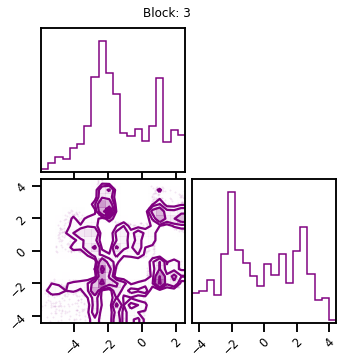

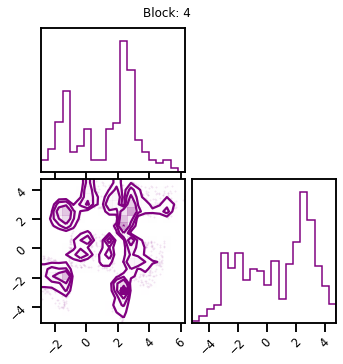

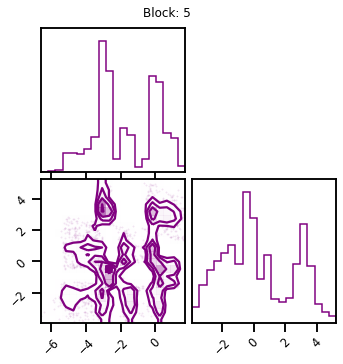

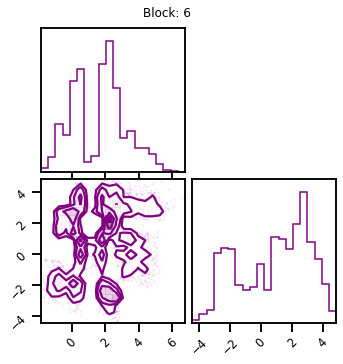

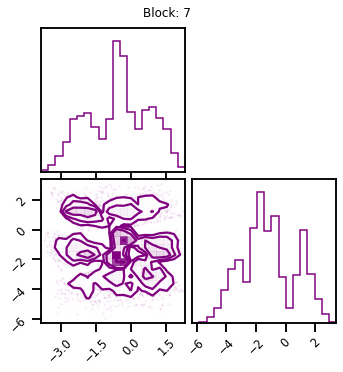

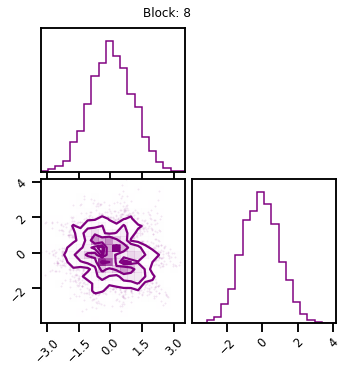

In [90]:
X_g = X.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")
plt.show()

for ilayer, ibijector in enumerate(gf_model.bijectors):

    X_g = ibijector.forward(X_g)

    if ibijector.name == "HouseHolder":
        fig = corner.corner(np.array(X_g), color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//2}")
        plt.show()

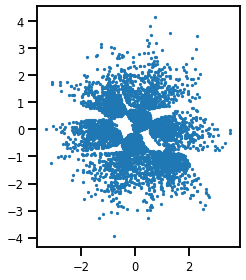

In [91]:
fig, ax = plt.subplots()
ax.scatter(X_g[:, 0], X_g[:, 1], s=3)
ax.set_aspect("equal", "box")
plt.tight_layout()

## Saving/Loading Model

In [78]:
import pickle

#### Save Model

In [79]:
import joblib

joblib.dump(final_bijector, "gf_model_spline.pickle")

['gf_model_spline.pickle']

#### Load Model

In [80]:
gf_model_loaded = joblib.load("gf_model_spline.pickle")